# Transfer Learning with Tensorflow part 2: Fine Tuning

In the previous notebook, we covered transfer learning feature extraction. Now it's time to learn a new kind of tranfer learning: fine-tuning.

In [1]:
import tensorflow as tf
!nvidia-smi
tf.config.list_physical_devices
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
!python --version
!nvcc --version


2025-08-02 04:52:59.051904: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-02 04:52:59.063666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754081579.077317    6993 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754081579.081609    6993 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754081579.090706    6993 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Sat Aug  2 04:53:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8              1W /   35W |      49MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Creating helper function
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

Always a good idea to use helper functions remember the don't repeat yourself rule

In [3]:
#!apt-get install wget
#!pip install scikit-learn
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
# Import helper functions we're going to use in the notebook
from helper_functions import *


> **Note** if you're running this notebook in Colab, the runtime may time out.  When the runtime runs out colab will delete the helper function so will need to redownload.

## Let's get some data

This time we're going to see how we can use the pre-trained models within tf.keras.applications and apply them to our own problem(recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [5]:
# Get 10% of training data of 10 classes of Food101
if(not os.path.exists("10_food_classes_10_percent.zip")):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
    unzip_data("10_food_classes_10_percent.zip")

In [6]:
# Checkout how many images and sub directories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [7]:
# Create training and test directory path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.


I0000 00:00:1754081581.935234    6993 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4098 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of batch of data
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[5.58673477e+00 5.58673477e+00 3.58673477e+00]
   [5.35714293e+00 5.35714293e+00 3.35714293e+00]
   [6.49489784e+00 6.49489784e+00 4.49489784e+00]
   ...
   [1.51147903e+02 1.28086685e+02 1.20142876e+02]
   [1.49959183e+02 1.29765335e+02 1.24362259e+02]
   [1.49510147e+02 1.31096909e+02 1.27096909e+02]]

  [[5.00000000e+00 5.00000000e+00 3.00000000e+00]
   [4.13775444e+00 4.13775444e+00 2.13775468e+00]
   [5.07142830e+00 5.07142830e+00 3.07142830e+00]
   ...
   [1.55443924e+02 1.30903168e+02 1.20816452e+02]
   [1.57428528e+02 1.34846924e+02 1.28709152e+02]
   [1.48311096e+02 1.28117279e+02 1.22714180e+02]]

  [[6.21428585e+00 6.21428585e+00 4.21428585e+00]
   [5.27040815e+00 5.27040815e+00 3.27040815e+00]
   [5.00000000e+00 5.00000000e+00 3.00000000e+00]
   ...
   [1.53831696e+02 1.26617432e+02 1.15403168e+02]
   [1.55698959e+02 1.31056137e+02 1.23341835e+02]
   [1.54010147e+02 1.31852066e+02 1.25142853e+02]]

  ...

  [[1.12285713e+02 4.04999771e+01 1.48571863e+01]
   [1

2025-08-02 04:53:02.946732: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model 0: building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility in desiging our models

In [12]:
# Create base model
efficentnet_b0 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    classes=10,
    classifier_activation='softmax',
)

efficentnet_b0.trainable = False

# create inputs for model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
# normalize, needed for some architectures
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = efficentnet_b0(inputs)
print(f"Shape after passing inputs through the base model:{x.shape}")
# average pool the outputs of base model(aggregate most important information, reduce computational expenses)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")
# create output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
# combine inputs and outputs into model
model_0 = tf.keras.Model(inputs,
                   outputs)

model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=["accuracy"])
history_model_0 = model_0.fit(train_data_10_percent,epochs=5,validation_data=test_data,validation_steps=int(0.25*len(test_data)),callbacks=[create_tensorboard_callback(dir_name="transfer learning",experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through the base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer learning/10_percent_feature_extraction/20250802-045304
Epoch 1/5


I0000 00:00:1754081590.831562    7097 service.cc:152] XLA service 0x70b958004a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754081590.831599    7097 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-08-02 04:53:11.049725: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754081592.140066    7097 cuda_dnn.cc:529] Loaded cuDNN version 91100
2025-08-02 04:53:13.984277: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11289', 60 bytes spill stores, 60 bytes spill loads

2025-08-02 04:53:14.010817: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusi

22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2154 - loss: 2.1936

2025-08-02 04:53:29.749431: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11289', 860 bytes spill stores, 860 bytes spill loads

2025-08-02 04:53:32.941190: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-02 04:53:33.031126: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-02 04:53:33.900440: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-02 04:53:33.994494: E external/local_xla/xla

24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 781ms/step - accuracy: 0.2337 - loss: 2.1639 - val_accuracy: 0.6826 - val_loss: 1.3623
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7140 - loss: 1.2750 - val_accuracy: 0.7895 - val_loss: 0.9555
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7822 - loss: 0.9233 - val_accuracy: 0.8076 - val_loss: 0.7709
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8284 - loss: 0.7143 - val_accuracy: 0.8355 - val_loss: 0.6546
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8604 - loss: 0.6286 - val_accuracy: 0.8503 - val_loss: 0.5949


In [13]:
model_0.evaluate(test_data)

77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8422 - loss: 0.6051

2025-08-02 04:53:53.799935: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2324', 756 bytes spill stores, 756 bytes spill loads

2025-08-02 04:53:56.538693: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-02 04:53:56.627499: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-02 04:53:57.469892: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-02 04:53:57.567050: E external/local_xla/xla/

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.8425 - loss: 0.6044


[0.5865685939788818, 0.8496000170707703]

In [14]:
# check the layers in our base model
for layer_number, layer in enumerate(efficentnet_b0.layers):
    print(f"Layer number:{layer_number} layer name:{layer.name}") 

Layer number:0 layer name:input_layer
Layer number:1 layer name:rescaling
Layer number:2 layer name:normalization
Layer number:3 layer name:stem_conv
Layer number:4 layer name:stem_bn
Layer number:5 layer name:stem_activation
Layer number:6 layer name:block1a_project_conv
Layer number:7 layer name:block1a_project_bn
Layer number:8 layer name:block1a_project_activation
Layer number:9 layer name:block2a_expand_conv
Layer number:10 layer name:block2a_expand_bn
Layer number:11 layer name:block2a_expand_activation
Layer number:12 layer name:block2a_project_conv
Layer number:13 layer name:block2a_project_bn
Layer number:14 layer name:block2b_expand_conv
Layer number:15 layer name:block2b_expand_bn
Layer number:16 layer name:block2b_expand_activation
Layer number:17 layer name:block2b_project_conv
Layer number:18 layer name:block2b_project_bn
Layer number:19 layer name:block2b_drop
Layer number:20 layer name:block2b_add
Layer number:21 layer name:block3a_expand_conv
Layer number:22 layer name

In [15]:
# summary of base model
efficentnet_b0.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          0 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [16]:
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

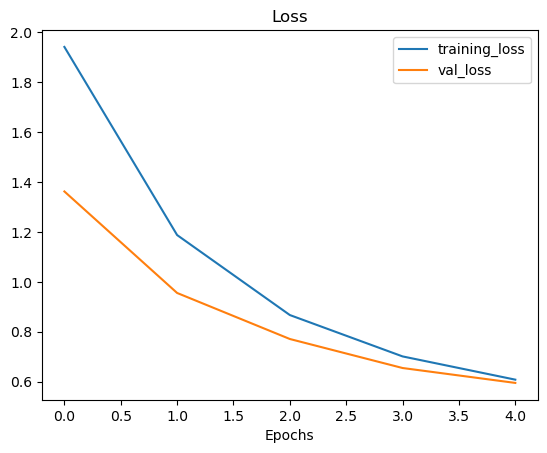

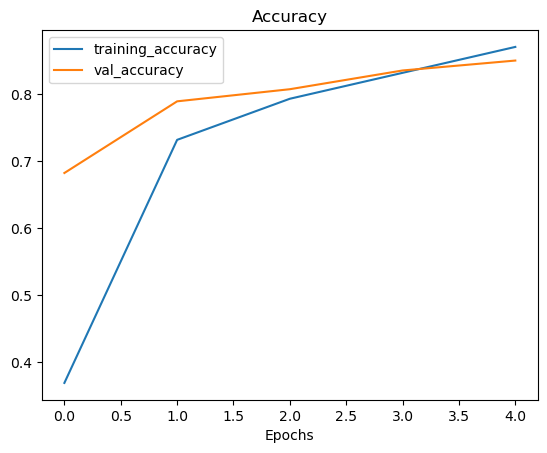

In [17]:
# Check out models training curves
plt.show(plot_loss_curves(history_model_0))

## Getting a feature vector from a trained model 
Let's demonstrate the Global Average Pooling 2d layer...
We have a tensor after our model goes through `base+model` of shape (None,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280)

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [18]:
# define input shape
input_shape =(1,4,4,3)
#create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Pass the random tensor through a random global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D: {global_average_pooled_tensor}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D: [[-0.09368646 -0.45840448 -0.2885598 ]]


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens

**Note** Onen of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector - a learned representation of the input data.

In [20]:
global_max_pool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor) 
print(global_max_pool_tensor)

tf.Tensor([[0.9058464 1.1603122 1.6994323]], shape=(1, 3), dtype=float32)


# Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with only 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning iwth 1% of the training data with augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning with 10% of the training data which will also use data augmentation
4. `model_4`- use fine-tuning transfer learning on 100% of the training data with data augmentation.
   
**Note**: throughout all experiments we will use the same test dataset, so that we can be consistent in evaluation

## Getting and preprocessing data for model 1

In [21]:
# Download and unzip data
 
if not os.path.exists("./10_food_classes_1_percent.zip"):
    !curl --output "10_food_classes_1_percent.zip" -X GET "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"
    unzip_data("./10_food_classes_1_percent.zip")

In [22]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [23]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [24]:
# Setup data loaders
IMG_SIZE = (224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Adding data augmentation right into the model


To add data augmentation right into our models, we can use the layers inside:

+ `tf.keras.layers.experimental.preprocessing()`

Benefits of data augmentation

+ More data - model may be better able to generalize
+ preprocessing of images(augmenting them) happens on the GPU which is far faster for this type of problem than the CPU
+ Image data augmentation only happens during training so we can still export out model and use it elsewhere.

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms,etc.
    
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.layers.Rescaling(1./255) - keep for models like resnet50V2 but for efficientnet it has rescaling built in
],name="data_augmentation")

### visualize our data augmentation layer(and check the data)

10_food_classes_1_percent/train/pizza


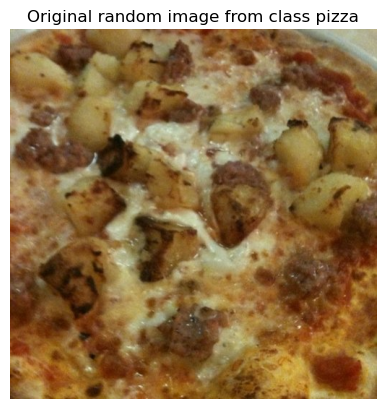

<Figure size 640x480 with 0 Axes>

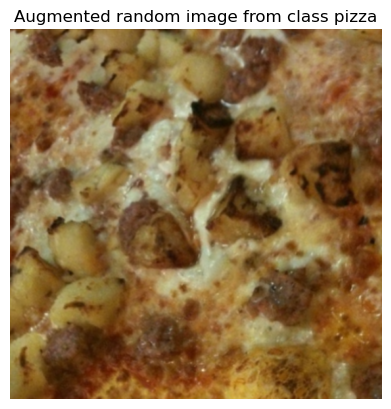

[[[179 180 148]
  [184 185 153]
  [178 179 148]
  ...
  [188 180 143]
  [189 181 144]
  [190 182 145]]

 [[173 174 142]
  [182 183 151]
  [180 181 150]
  ...
  [187 179 142]
  [188 180 143]
  [188 180 143]]

 [[172 173 142]
  [183 184 153]
  [183 186 157]
  ...
  [187 179 143]
  [187 179 143]
  [186 178 142]]

 ...

 [[ 78  44  19]
  [ 84  50  23]
  [ 86  51  23]
  ...
  [132  96  46]
  [131  95  43]
  [127  91  39]]

 [[ 80  48  25]
  [ 84  52  27]
  [ 83  49  21]
  ...
  [130  94  44]
  [129  93  41]
  [124  88  36]]

 [[ 74  42  19]
  [ 81  49  24]
  [ 82  48  21]
  ...
  [134  98  48]
  [132  96  44]
  [126  90  38]]]
2924941.jpg


In [26]:
# View a random image and compare it to the augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(target_dir)
# read in random image + plot
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)
# now let's plot augmented random image
augmented_image = data_augmentation(img)
plt.figure()
plt.show()
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_image / 255.))
plt.show()
print(img)
print(random_image)

In [27]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
], name="data_augmentation")

## Model 1: Feature extraction on transfer learning on 1% of the data using data augmentation

In [28]:

# Setup input shape and base model freezing the base model layers
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Crete input layer
inputs = layers.Input(shape=input_shape,name="input_layer")
print(inputs)
# add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# GIve base_model the inputs(after augmentation) & don't train it

x = base_model(x,training=False)

# Pool output features of the base model

x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="ouput_layer")(x)

# Make a model using inputs and outpus

model_1 = keras.Model(inputs,outputs)

# compile the model

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_1_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="1_percent_data_aug")])

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=input_layer>
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250802-045405
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.1086 - loss: 2.4154 - val_accuracy: 0.1859 - val_loss: 2.2460
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 945ms/step - accuracy: 0.2191 - loss: 2.1306 - val_accuracy: 0.2204 - val_loss: 2.1270
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 944ms/step - accuracy: 0.4057 - loss: 1.9665 - val_accuracy: 0.3109 - val_loss: 2.0030
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 953ms/step - accuracy: 0.4629 - loss: 1.7747 - val_accuracy: 0.3586 - val_loss: 1.9085
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 944ms/step - accuracy: 0.6196 - loss: 1.6363 - val_accuracy: 0.4194 - val_loss: 1.8322


In [29]:
# Checkout model 1 summary
model_1.summary()
history_1_percent.history

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling_layer        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ouput_layer (Dense)             │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

{'accuracy': [0.10000000149011612,
  0.24285714328289032,
  0.4285714328289032,
  0.4571428596973419,
  0.6142857074737549],
 'loss': [2.409687042236328,
  2.1128246784210205,
  1.9417221546173096,
  1.7710115909576416,
  1.6289535760879517],
 'val_accuracy': [0.18585526943206787,
  0.22039473056793213,
  0.31085526943206787,
  0.35855263471603394,
  0.4194079041481018],
 'val_loss': [2.246030330657959,
  2.127049207687378,
  2.003021240234375,
  1.9084781408309937,
  1.8322181701660156]}

In [30]:
# Evaluate on full data set
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.4371 - loss: 1.8141


[1.8027433156967163, 0.44920000433921814]

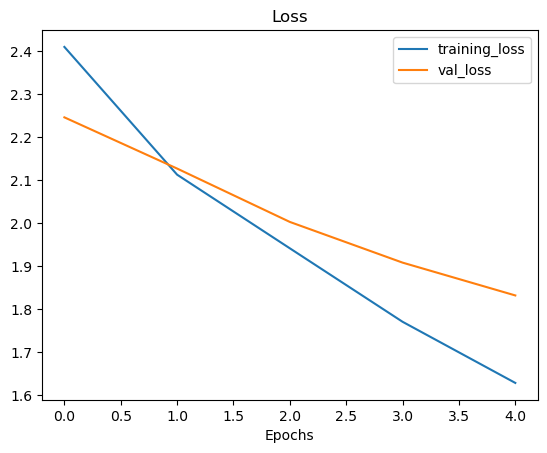

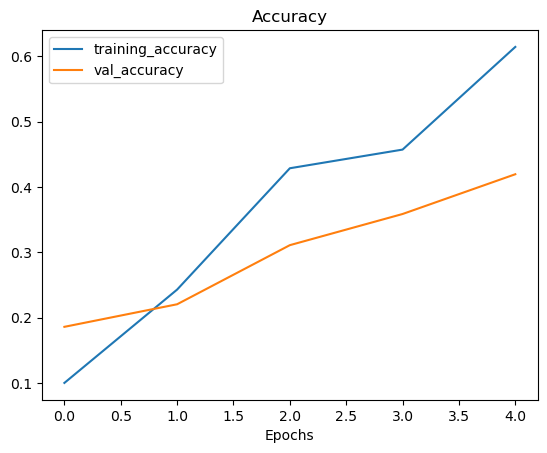

In [31]:
# Plot loss curves for data augmentation with 1 percent
plt.show(plot_loss_curves(history_1_percent))


## Model 2: Feature extraction on transfer learning on 10% of the data using data augmentation

In [32]:
train_dir_10_percent = "./10_food_classes_10_percent/train"
test_dir_10_percent = "./10_food_classes_10_percent/test"

In [33]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
# How many images are in dir
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [35]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
    # if using another model rescaling may be needed as efficientNet has rescaling built in
])
# Setup input 

In [36]:
# Setup input shape and base model freezing the base model layers
tf.random.set_seed(42)

input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Crete input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs(after augmentation) & don't train it
x = base_model(x,training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="ouput_layer")(x)

# Make a model using inputs and outpus
model_2 = keras.Model(inputs,outputs)

# compile the model

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model
history_10_percent = model_2.fit(train_data,
                               epochs=5,
                               steps_per_epoch=len(train_data),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_data_aug")])
data_augmentation.summary()

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250802-045437
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.1869 - loss: 2.2503 - val_accuracy: 0.6546 - val_loss: 1.4754
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.6617 - loss: 1.4532 - val_accuracy: 0.7928 - val_loss: 0.9996
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.7595 - loss: 1.0899 - val_accuracy: 0.8076 - val_loss: 0.8210
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.7842 - loss: 0.9338 - val_accuracy: 0.8289 - val_loss: 0.6981
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.7908 - loss: 0.7842 - val_accuracy: 0.8355 - val_loss: 0.6370


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_2 (RandomHeight)  │ (None, None, 224, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_2 (RandomWidth)    │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, None, None, 3)  │             0 │
│ (RandomRotation)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, None,      │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, None,      │          7 │ rescaling_3[0][0] │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, None,      │          0 │ normalization_2[… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_4[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [38]:
model_2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling_layer        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ouput_layer (Dense)             │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

In [39]:
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

## Creating a model checkpoint callback

The ModelCheckpoint callback intermediately saves our model(full model or just weights) during training.  This is useful so we can pause training and come back.

In [40]:
checkpoint_path='./ten_percent_model_checkpoints-weights/checkpoint.weights.h5'

# Create a model checkpoint callback to save weights
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    save_freq='epoch', # save every epoch
    verbose=1)


In [41]:
history_10_percent = model_2.fit(train_data,
                               epochs=5,
                               steps_per_epoch=len(train_data),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_data_aug"),model_checkpoint_callback])
data_augmentation.summary()

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250802-045514
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8347 - loss: 0.6966
Epoch 1: saving model to ./ten_percent_model_checkpoints-weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.8341 - loss: 0.6972 - val_accuracy: 0.8470 - val_loss: 0.5899
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8227 - loss: 0.6773
Epoch 2: saving model to ./ten_percent_model_checkpoints-weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.8225 - loss: 0.6762 - val_accuracy: 0.8487 - val_loss: 0.5681
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8496 - loss: 0.5786
Epoch 3: saving model to ./ten_percent_model_checkpoints-weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.8492 - loss: 0.5792 - val_accuracy: 0.8618 - val_loss: 0.5118
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height_2 (RandomHeight)  │ (None, None, 224, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width_2 (RandomWidth)    │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, None, None, 3)  │             0 │
│ (RandomRotation)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
# What were model 0 results
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8522 - loss: 0.5949


[0.5865688920021057, 0.8496000170707703]

In [43]:
# check model 2 results on all test data 
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.8538 - loss: 0.5057


[0.5079969167709351, 0.8511999845504761]

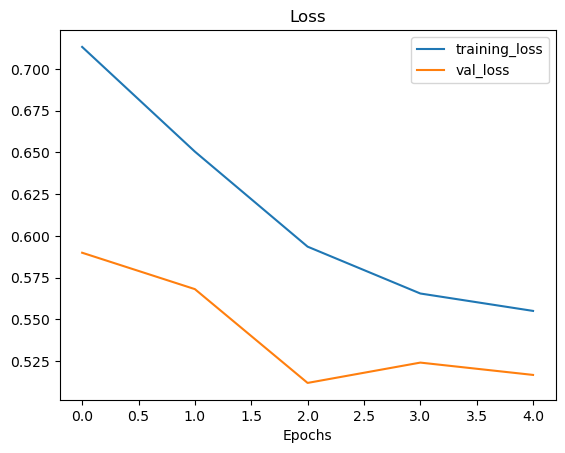

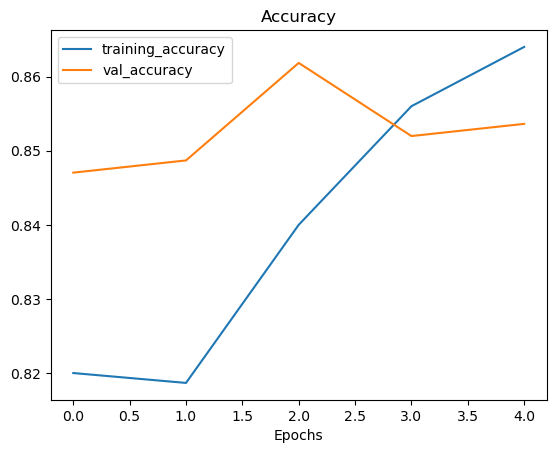

In [44]:
# Plot model loss curves
plt.show(plot_loss_curves(history_10_percent))


### Loading in checkpointed weights

Loadining in checkpointed weights returns a model to a specific checkpoint

In [45]:
# load in saved model weights and evaluate weights
model_2.load_weights(checkpoint_path)

In [46]:
# evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.8625 - loss: 0.4946


In [47]:
# if the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [48]:
loaded_weights_model_results

[0.5079972743988037, 0.8511999845504761]

In [49]:
results_10_percent_data_aug

[0.5079969167709351, 0.8511999845504761]

In [50]:
# Check to see if loaded model results are very close to our previous non loaded results(precision issue)

import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [51]:
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-3.57627869e-07  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

**Note:** Fine-tuning usually works best *after* training a feataure extraction model for a few epochs with large amounts of custom data

In [52]:
# Layers in loaded model:
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=sequential, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <GlobalAveragePooling2D name=global_avg_pooling_layer, built=True>,
 <Dense name=ouput_layer, built=True>]

In [53]:
# Are layers trainable
for layer in model_2.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=sequential, built=True> True
<Functional name=efficientnetb0, built=True> False
<GlobalAveragePooling2D name=global_avg_pooling_layer, built=True> True
<Dense name=ouput_layer, built=True> True


In [54]:
# What layers are in our base_model(EfficientNetB0) and are they trainable?
for i,layer in enumerate(model_2.layers[2].layers):
    print(layer.name, layer.trainable)

input_layer_4 False
rescaling_3 False
normalization_2 False
rescaling_4 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
bl

In [55]:
# how many trainable variables are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [56]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base model.trainable =True
base_model.trainable = True
# Freeze all layers except for last 10
for i,layer in enumerate(model_2.layers[2].layers[:-10]):
    layer.trainable= False
# Recompile (We have to recompile our models after every change we make)
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine-tuning you typically want to lower the learning rate by 10X
               metrics=["accuracy"])

> **Note:** when using fine-tuning it's best practice to lower your learning rate by some amount.  How much?  This is hyperparameter you can tune.  But a good rule of thumb is 10X but sources may vary.  A good resource for this is the ULMFiT paper for fine-tuning for text classification https://arxiv.org/abs/1801.06146.

In [57]:
# check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_layer_4 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [58]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there

print(len(model_2.trainable_variables))

12


In [59]:
print(model_2.trainable_variables)

[<Variable path=block7a_se_reduce/kernel, shape=(1, 1, 1152, 48), dtype=float32, value=[[[[-0.05485657  0.07178846  0.01534605 ... -0.09284662  0.0104828
    -0.02693838]
   [-0.03157939  0.02819107 -0.05579546 ...  0.00487578  0.12001809
    -0.06901816]
   [-0.07792544  0.12601745  0.03935236 ...  0.03086486 -0.01581392
     0.1306234 ]
   ...
   [-0.07692936  0.19920062  0.17471024 ...  0.03312391 -0.04528928
    -0.09214652]
   [ 0.01010198  0.06855008  0.05820991 ...  0.00131649 -0.08952942
    -0.00476829]
   [ 0.03583075 -0.01228165  0.04561347 ... -0.00822134 -0.07354517
    -0.06507882]]]]>, <Variable path=block7a_se_reduce/bias, shape=(48,), dtype=float32, value=[-0.10886215 -0.13624744 -0.15257476  0.14799541 -0.08512902 -0.12059905
 -0.08779966 -0.08187538 -0.06925284 -0.12518929 -0.0819265  -0.1259736
 -0.09993652 -0.10109923 -0.13398036 -0.09867296 -0.09382621 -0.11011569
 -0.1063069  -0.09003814 -0.04766154 -0.06743164 -0.13778378 -0.10579358
 -0.10130141 -0.13948615  0.

In [60]:
# Fine tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5
# refit the model(Same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                              epochs=fine_tune_epochs,
                                              validation_data=test_data,
                                              validation_steps=int(0.25 * len(test_data)),
                                              initial_epoch=history_10_percent.epoch[-1], # start training from previous last epoch
                                              callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                       experiment_name="10_percent_fine_tune_last_10")]
                                              )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20250802-045559
Epoch 5/10


E0000 00:00:1754081767.973160    6993 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 334ms/step - accuracy: 0.8346 - loss: 0.6429 - val_accuracy: 0.8651 - val_loss: 0.4876
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.8331 - loss: 0.5607 - val_accuracy: 0.8701 - val_loss: 0.4452
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.8925 - loss: 0.4467 - val_accuracy: 0.8618 - val_loss: 0.4635
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9023 - loss: 0.4205 - val_accuracy: 0.8536 - val_loss: 0.4375
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9019 - loss: 0.4192 - val_accuracy: 0.8684 - val_loss: 0.4114
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.8984 - loss: 0.4101 - val_accuracy: 0.8668 - val_loss: 0.4083


In [61]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tuned_10_percent = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.8689 - loss: 0.4119


In [62]:
results_10_percent_data_aug

[0.5079969167709351, 0.8511999845504761]

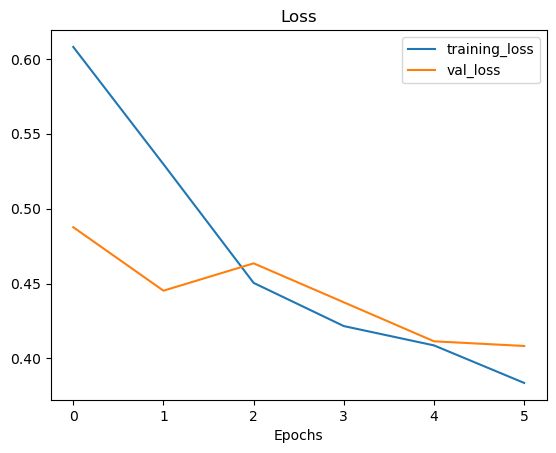

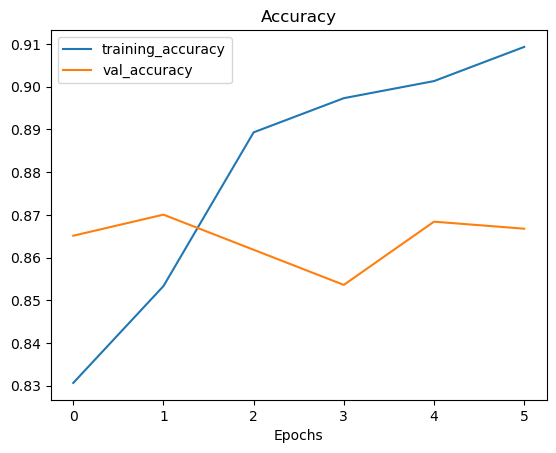

In [63]:
# checkout the loss curves of our fine_tuned_model

plt.show(plot_loss_curves(history_fine_10_percent_data_aug))

The `plot_loss_curves` function works great with models which have only beeen fit once, however, we want something to compare one series of running `fit()` with another(eg: before and after fine-tuning)

In [96]:
# Let's create a funciton
def compare_histories(original_history,new_history,initial_epochs=5, fine_tuning=True):
    """
    Compares two Tensorflow History object.s
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    # combine original history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss  + new_history.history["loss"]
    
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]
    if fine_tuning:
        # make plots
        plt.figure(figsize=(8,8))
        plt.subplot(2,1,1)
        plt.plot(total_acc, label="Training Accuracy")
        plt.plot(total_val_acc, label="Val accuracy")
        plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
        plt.legend(loc="lower right")
        plt.title("Training and Validation Accuracy")
    
        plt.figure(figsize=(8,8))
        plt.subplot(2,1,1)
        plt.plot(total_loss, label="Training Loss")
        plt.plot(total_val_loss, label="Val Loss")
        plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
        plt.legend(loc="upper right")
        plt.title("Training and Validation Loss")
    else:
              # make plots
        plt.figure(figsize=(8,8))
        plt.subplot(2,1,1)
        plt.plot(total_acc, label="Training Accuracy")
        plt.plot(total_val_acc, label="Val accuracy")
        plt.legend(loc="lower right")
        plt.title("Training and Validation Accuracy")
    
        plt.figure(figsize=(8,8))
        plt.subplot(2,1,1)
        plt.plot(total_loss, label="Training Loss")
        plt.plot(total_val_loss, label="Val Loss")
        plt.legend(loc="upper right")
        plt.title("Training and Validation Loss")

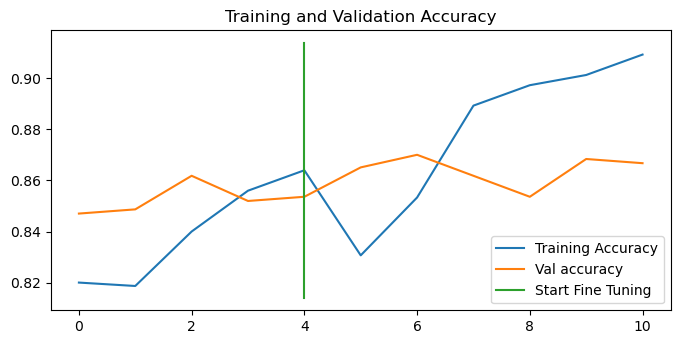

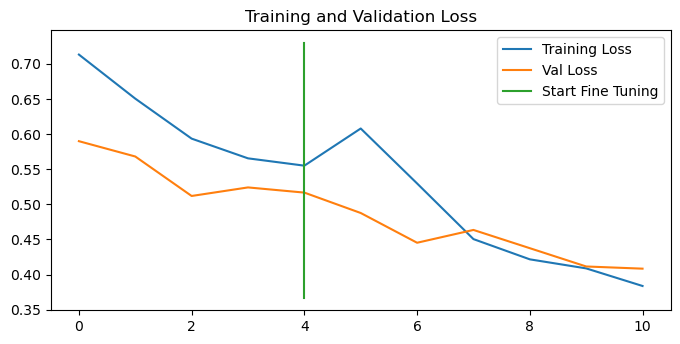

In [93]:
plt.show(compare_histories(history_10_percent,history_fine_10_percent_data_aug))

## Model 4:  Fine-tuning and existing model on all of the data

In [66]:
# Download and unzip 10 classes of Food101 with all images
if(not os.path.exists("10_food_classes_all_data.zip")):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

In [67]:
# Setup training and test dirs
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [68]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [69]:
# Setupu data inputs
import tensorflow as tf

IMG_SIZE=(224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             label_mode="categorical",
                                                             image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this....

In [70]:
# Evaluate model 2(this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.8567 - loss: 0.4084


[0.4230901896953583, 0.8615999817848206]

In [71]:
results_fine_tuned_10_percent

[0.4230906367301941, 0.8615999817848206]

To train a fine-tuning model (model_4) we need to revert model_2 back to it's feature extraction weights.

In [72]:
# Load weights from checkpoint, that way we can fine-tune from
# The same stage the 10 percent data model was fine_tuned from
model_2.load_weights(checkpoint_path)

/usr/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [73]:
# Lets evaluate model 2 now
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.8500 - loss: 0.5090


[0.5079967975616455, 0.8511999845504761]

In [74]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.5079969167709351, 0.8511999845504761]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer-learning model for 5 epochs on 10% of the data with data augmentation(model_2) and we've saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen(model_3)
3. Saved the resutls and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data(model_4)

In [75]:
# Check which laysers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 sequential True
2 efficientnetb0 True
3 global_avg_pooling_layer True
4 ouput_layer True


In [76]:
# Let's drill into our base_model(efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_layer_4 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [77]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [78]:
# Continue to train and fine-tune the model to our data(100% of our training data)
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          initial_epoch=5,
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20250802-045708
Epoch 6/10


E0000 00:00:1754081834.985408    6993 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


235/235 ━━━━━━━━━━━━━━━━━━━━ 45s 163ms/step - accuracy: 0.7556 - loss: 0.7887 - val_accuracy: 0.8816 - val_loss: 0.3383
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.8151 - loss: 0.5921 - val_accuracy: 0.8882 - val_loss: 0.3149
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.8290 - loss: 0.5362 - val_accuracy: 0.8865 - val_loss: 0.3016
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.8498 - loss: 0.4756 - val_accuracy: 0.9095 - val_loss: 0.2662
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 36s 154ms/step - accuracy: 0.8629 - loss: 0.4402 - val_accuracy: 0.9079 - val_loss: 0.2649


In [79]:
# let's evaluate on all test data
results_fine_tune_full_data=model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9004 - loss: 0.2729


[0.277459979057312, 0.9007999897003174]

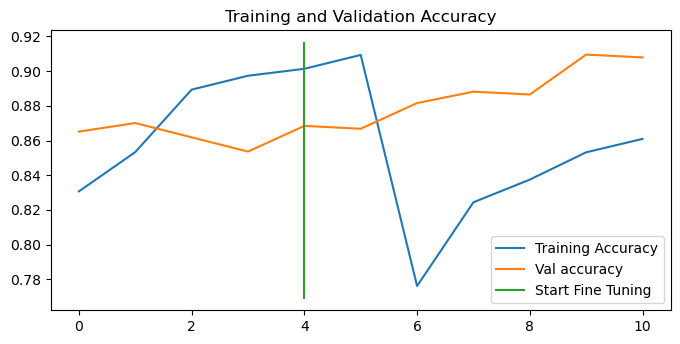

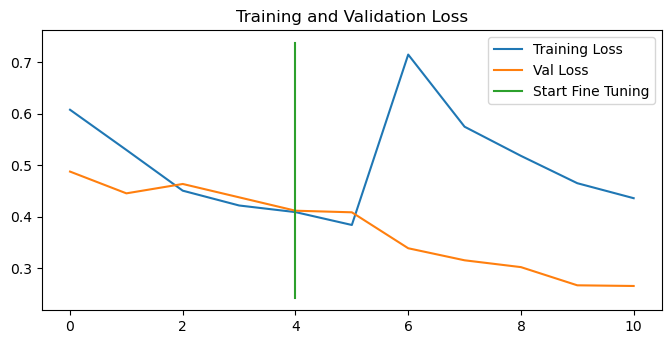

In [80]:
# How did fine-tuning go with more data?
compare_histories(original_history=history_fine_10_percent_data_aug, new_history=history_fine_10_classes_full)

## Viewing our experiment data on TensorBoard

> **Note:** Anything you upload to TensorBoard.dev is going to be public.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments(should be 4 models)
# Upload Tensorboard dev records tensorboard dev deprecated

# !tensorboard --logdir ./transfer_learning

### Exercise: recreate one of experiments using **tf.keras.applications.EfficientNetB4**

In [83]:
# Create base model
efficentnet_b4 =tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    classes=10,
    classifier_activation='softmax',
)

efficentnet_b4.trainable = False

# create inputs for model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
# normalize, needed for some architectures
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = efficentnet_b4(inputs)
print(f"Shape after passing inputs through the base model:{x.shape}")
# average pool the outputs of base model(aggregate most important information, reduce computational expenses)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")
# create output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
# combine inputs and outputs into model
model_6 = tf.keras.Model(inputs,
                   outputs)

model_6.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=["accuracy"])
history_model_6 = model_6.fit(train_data_10_percent,epochs=5,validation_data=test_data,validation_steps=int(0.25*len(test_data)),callbacks=[create_tensorboard_callback(dir_name="transfer learning",experiment_name="10_percent_feature_extraction_efficientnetB4")])

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step
Shape after passing inputs through the base model:(None, 7, 7, 1792)
Shape after GlobalAveragePooling2D:(None, 1792)
Saving TensorBoard log files to: transfer learning/10_percent_feature_extraction_efficientnetB4/20250802-050553
Epoch 1/5


2025-08-02 05:06:04.998532: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22576', 4 bytes spill stores, 4 bytes spill loads

2025-08-02 05:06:05.141777: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22576', 60 bytes spill stores, 60 bytes spill loads

2025-08-02 05:06:05.517758: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22576', 1180 bytes spill stores, 1244 bytes spill loads

2025-08-02 05:06:05.673559: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22576', 948 bytes spill stores, 948 bytes spill loads

2025-08-02 05:06:06.954395: E ex

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3398 - loss: 2.0560

2025-08-02 05:06:31.970770: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22576', 860 bytes spill stores, 860 bytes spill loads

2025-08-02 05:06:36.344713: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-02 05:06:36.437637: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-02 05:06:36.716480: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-02 05:06:36.812511: E external/local_xla/xla

24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3524 - loss: 2.0331 - val_accuracy: 0.7878 - val_loss: 1.1292
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.7625 - loss: 1.0857 - val_accuracy: 0.8273 - val_loss: 0.7582
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.7889 - loss: 0.8113 - val_accuracy: 0.8503 - val_loss: 0.6064
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.8180 - loss: 0.6669 - val_accuracy: 0.8536 - val_loss: 0.5671
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.8508 - loss: 0.5582 - val_accuracy: 0.8520 - val_loss: 0.5036


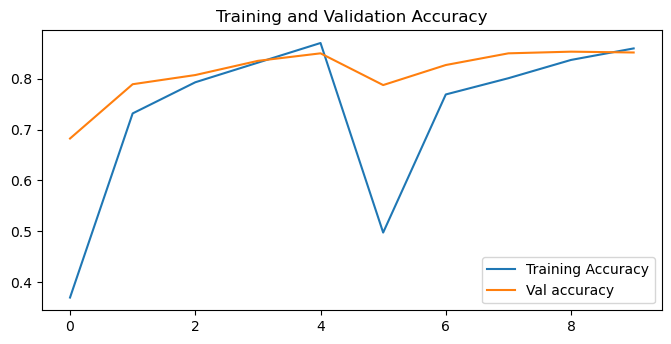

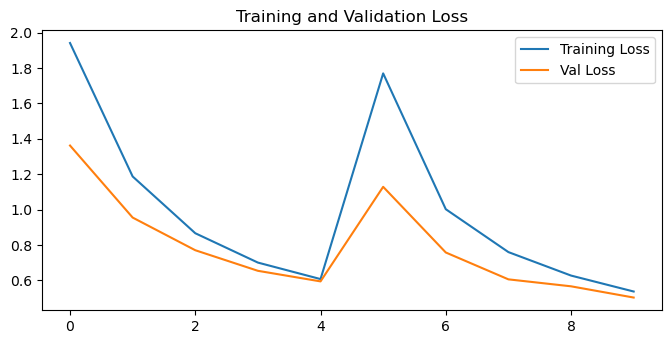

In [97]:
plt.show(compare_histories(history_model_0,history_model_6,0,False))